# Let's Train GPT-2




#### 8 x A100 Training Instructions:

1. Set up a training run with a lower batch size of 32 and a single iteration. This will allow jax to compile the model without running out of memory.
2. Then, start a new training run with a batch size of 64 and for the complete set of iterations. Do not reset the dataloader between the two runs.


### Install Packages


In [1]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout lambda && git pull
    !pip install tiktoken --quiet
    !pip uninstall -y tensorflow
    !pip install flash-attention-jax

Cloning into 'jaxpt'...
remote: Enumerating objects: 369, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 369 (delta 106), reused 71 (delta 63), pack-reused 217 (from 1)
Receiving objects: 100% (369/369), 4.31 MiB | 1.74 MiB/s, done.
Resolving deltas: 100% (212/212), done.
Branch 'lambda' set up to track remote branch 'lambda' from 'origin'.
Switched to a new branch 'lambda'
Already up to date.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.6 MB/s eta 0:00:00
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0


In [2]:
from pathlib import Path
import sys

if is_colab():
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )

sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/content/jaxpt/src


In [3]:
import jax
import optax
import jax.numpy as jnp
import numpy as np
from flax import nnx
import tiktoken

import jaxpt
from jaxpt.dataloaders import DataLoader
from jaxpt.models import GPT2, GPTConfig, save_checkpoint as save_gpt2_chkpt , from_checkpoint as load_gpt2_chkpt
from jaxpt.train import train_step, parallel_train_step, accum_train_step, loss_fn, compute_global_norm
from jaxpt.infer import generate

### Configure compute

In [4]:
import os

os.environ['XLA_FLAGS'] = (
    '--xla_gpu_triton_gemm_any=True '
    '--xla_gpu_enable_latency_hiding_scheduler=true '
)

os.environ.update({
  "NCCL_LL128_BUFFSIZE": "-2",
  "NCCL_LL_BUFFSIZE": "-2",
   "NCCL_PROTO": "SIMPLE,LL,LL128",
 })


# Hardware setup
print("JAX version:", jax.__version__)
devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)

jax.config.update("jax_platform_name", "gpu") # Make sure we're using the GPU
#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
jax.config.update("jax_default_matmul_precision", "bfloat16") # Set the default precision for matrix multiplication

os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

def list_tpu_memory():
    devices = jax.devices()
    for device in devices:
        if 'TPU' in str(device.device_kind):
            print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

#list_tpu_memory()

print("Using device:", jax.default_backend())  # Should print 'gpu'

A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Makes sure the matmul is fast

#%timeit (A@A).block_until_ready()

JAX version: 0.5.2
Available devices: 1
Using device: gpu


### Configure Training Run

In [10]:
from functools import partial

import orbax.checkpoint as ocp


from datetime import datetime
import random
import string

def generate_random_code(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

timestamp = datetime.now().strftime("%Y%m%d")
random_code = generate_random_code()
run_dir = f"run_{timestamp}_{random_code}"
print(run_dir)

#output_dir = Path("/home/ubuntu/gpt2-train")
output_dir = Path().absolute().parent
checkpoint_dir =   output_dir / "checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Checkpoint directory: {checkpoint_dir}")

log_dir = output_dir / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
print(f"Log directory: {log_dir}")

def save_checkpoint(m, step):
  checkpoint_path = checkpoint_dir / run_dir / f"checkpoint-{step}.pt"
  save_gpt2_chkpt(m, checkpoint_path)

def load_checkpoint(run_dir, step):
  checkpoint_path = checkpoint_dir / run_dir / f"checkpoint-{step}.pt"
  m = load_gpt2_chkpt(checkpoint_path, rngs)
  return m




run_20250312_rvkdrm
Checkpoint directory: /checkpoints
Log directory: /logs


### Initialize the GPT-2 model and perform a sanity check

In [6]:
"""
+--------------+---------+--------+------+
| Model        | Layers  | Heads  | Embd |
+--------------+---------+--------+------+
| gpt2-medium  | 24      | 16     | 1024 |
| gpt2-large   | 36      | 20     | 1280 |
| gpt2-xl      | 48      | 25     | 1600 |
+--------------+---------+--------+------+
"""

key = jax.random.PRNGKey(0)
rngs = nnx.Rngs(key)
config = GPTConfig(dtype=jnp.bfloat16, sdpa_implementation="cudnn")
m = GPT2(config, rngs)
#m = load_checkpoint("run_20250311_uqdwjq", 5600)
graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
nnx.display(state)

def generate_completions():
  m.eval()
  num_completions = 5
  max_length = 20
  generate_completion = partial(generate, m, max_length=max_length)
  prefix = "The clever jackal"
  enc = tiktoken.get_encoding('gpt2')
  tokens = enc.encode(prefix)
  tokens = jnp.array(tokens, dtype=jnp.int32)
  tokens = jnp.expand_dims(tokens, axis=0)
  x = jnp.tile(tokens, (num_completions, 1))


  x = generate_completion(x=x) # Make sure you can do a forward pass
  output = []
  for i in range(num_completions):
      tokens = x[i, :max_length].tolist()
      decoded = enc.decode(tokens)
      output.append(decoded)
  return output

#completions = generate_completions()
#for completion in completions:
#print(completion)


In [ ]:
import dataclasses

############################
# Nvidia A100 (x 8) Config #
############################

@dataclasses.dataclass()
class TrainerConfig:
  num_tokens_per_batch: int = 2**14 # 2**19, 0.5 million as per the GPT 3.5 paper
  mB: int = 16
  T: int = 1024
  max_steps: int = 18883 # 1 epoch (all 99 shards of the dataset)
  max_lr: float = 6e-4
  min_lr: float = max_lr * 0.1
  max_grad_norm: float = 1.0  # Clip gradients to this norm
  warmup_steps: int = 715
  print_interval: int = 1
  eval_interval: int = 100
  checkpoint_interval: int = 100
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T * num_devices) # Number of steps over which to average the gradient


##############
# CPU Config #
##############

trconf = TrainerConfig()
'''
trconf = TrainerConfig(
  num_tokens_per_batch=2**9,
  mB=8,
  T=64,
  max_steps=286*10, # 6 epoch(s)
  max_lr=6e-4,
  min_lr=6e-5,
  max_grad_norm=1.0,
  warmup_steps=10,
  print_interval=1,
  eval_interval=50,
  checkpoint_interval=100,

)
'''
trconf.grad_accumulation_steps =  trconf.num_tokens_per_batch // (trconf.mB * trconf.T * num_devices) # Number of steps over which to average the gradient

# Set up the optimizer
def warmup_with_cosine_decay_schedule(step):

    warmup_lr = trconf.max_lr * (step + 1) / trconf.warmup_steps
    coeff = 0.5 * (1 + jnp.cos(jnp.pi * (step - trconf.warmup_steps) / (trconf.max_steps - trconf.warmup_steps)))
    cosine_lr =  trconf.min_lr + coeff * (trconf.max_lr - trconf.min_lr)

    return jnp.where(step < trconf.warmup_steps,
                     warmup_lr,
                     jnp.where(step < trconf.max_steps, cosine_lr, trconf.min_lr))

# Generate a weight decay mask
# First split the model into params and variables
graphdef, params, variables = nnx.split(m, nnx.Param, nnx.Variable)
# Then create a mask for the weight decay params
weight_decay_mask = jax.tree_util.tree_map(lambda x: len(x.shape) > 1, params)


tx = optax.chain(
    optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adamw(6e-4, b1=0.9, b2=0.95, weight_decay=0.1, mask=weight_decay_mask)
)
optimizer = nnx.Optimizer(m, tx)

# count the number of weight decay params
def f(x, y):
    if x:
        return y.size
    return 0

weight_decay_params = jax.tree_util.tree_map(f, weight_decay_mask, params)
weight_decay_param_count = jax.tree_util.tree_reduce(lambda x, y: x + y, weight_decay_params, 0)


print(f"weight decay param count: {weight_decay_param_count:,}")
print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"sub-batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB)
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB * num_devices}")
print(f"max steps: {trconf.max_steps}")


### DataLoader and Validation Setup



In [12]:

dataset = "panchatantra-ryder"

if is_colab():
    dataset_path = Path().absolute() / "jaxpt" / "src" / "jaxpt" / "datasets" / dataset / "processed"
else:
    if dataset == "fineweb-edu":
      dataset_path = "/home/ubuntu/gpt2-train/fineweb-edu/processed"
    elif dataset == "panchatantra-ryder":
      dataset_path = Path().absolute().parent / "src"/ "jaxpt" / "datasets" / dataset / "processed"
    else:
      raise ValueError(f"Dataset {dataset} not found")

train_dl = DataLoader(dirpath=dataset_path, batch_size=trconf.mB, block_size=trconf.T, device_rank=num_devices, label="train")
eval_dl = DataLoader(dirpath=dataset_path, batch_size=trconf.mB, block_size=trconf.T, device_rank=1, label="valid", quiet=True)

def validate(m):
  valid_loss = 0.0
  eval_steps = 10
  for i in range(eval_steps):
    batch, targets = eval_dl()
    batch = np.squeeze(batch)
    targets = np.squeeze(targets)
    loss = loss_fn(m, batch, targets)
    valid_loss += loss
  valid_loss /= eval_steps
  return valid_loss

def evaluate(m):
  m.eval()
  completions =generate_completions()
  val_loss = validate(m)
  m.train()
  return val_loss, completions



dataloader initialized:
------------------------
label:          train
shards:         1
shard size:     146,776
batch size:     16
block size:     1024
device rank:    1
------------------------


### Let's train the model

0 | lr: 8.39e-07 | loss: 11 | norm: 0.00 | time: 29309.49ms | tokens processed: 32,768 | tok/sec: 1,118.00
valid loss: 9.0625
The clever jackal farming had sacrificeourcing Eleanorwhile  Bentleyーク . purporteditions============units Eleanor
The clever jackal Ans fellowoshourcingmany ends sheer Motorsport painstaking, Ded harmedaredared Ankara is
The clever jackal Gundam painstaking  accuse theAn ends is penchant
 is
techn,, robber
The clever jackalScar precision sacrifice is escape Chungared Dodgers accuse��� farming painstaking
 dress whip jointly
The clever jackal Orimany precision escape accuse
osh penchantAn defining, Ankara whipitions Ori blaze
1 | lr: 1.68e-06 | loss: 9.0625 | norm: 0.00 | time: 507.04ms | tokens processed: 65,536 | tok/sec: 64,625.45
2 | lr: 2.52e-06 | loss: 9.75 | norm: 0.00 | time: 154.60ms | tokens processed: 98,304 | tok/sec: 211,952.90
3 | lr: 3.36e-06 | loss: 8.375 | norm: 0.00 | time: 160.12ms | tokens processed: 131,072 | tok/sec: 204,648.94
4 | lr: 4.20e

TypeError: expected number, got jaxlib.xla_extension.ArrayImpl

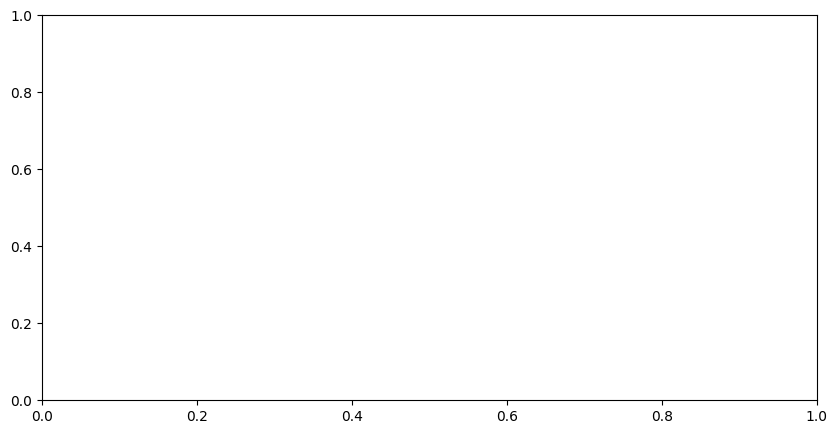

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

import time
from functools import partial

import logging
import warnings

from jaxpt.utils import append_to_csv


warnings.filterwarnings("ignore", message="Conversion for .*PmapSharding.*")
logging.getLogger("root").setLevel(logging.ERROR)

train_losses = []
val_losses = []
append_to_csv(log_dir / f"{run_dir}_train.csv", ["step", "lr", "loss", "norm", "time", "tokens_processed", "tokens_per_sec"])
append_to_csv(log_dir / f"{run_dir}_valid.csv", ["step", "loss"])

m.train()
try:
  for step in range(trconf.max_steps):
    start = time.time()
    batch, target = train_dl()
    avg_loss, avg_grads = parallel_train_step(m, optimizer, batch, target)
    #avg_loss, avg_grads = train_step(m, optimizer, batch, target)
    avg_loss.block_until_ready()
    # compute stats
    avg_loss = avg_loss[0]
    lr = warmup_with_cosine_decay_schedule(step)
    norm = 0 # norm[0]|
    iter_time = time.time() - start
    sub_step_time = iter_time / trconf.grad_accumulation_steps
    tokens_per_sec = num_devices * trconf.mB * trconf.T * trconf.grad_accumulation_steps / iter_time
    tokens_processed = (step+1) * num_devices * trconf.grad_accumulation_steps * trconf.mB * trconf.T

    if step % trconf.print_interval == 0:
      train_losses.append((step, avg_loss))
      append_to_csv(log_dir / f"{run_dir}_train.csv", [step, lr, avg_loss, norm, iter_time*1000, tokens_processed, tokens_per_sec])
      print(f"{step} | lr: {lr:0.2e} | loss: {avg_loss} | norm: {norm:0.2f} | time: {iter_time*1000:0.2f}ms | tokens processed: {tokens_processed:,} | tok/sec: {tokens_per_sec:,.2f}")
    if step % trconf.eval_interval == 0:
      valid_loss, completions = evaluate(m)
      val_losses.append((step, valid_loss))
      append_to_csv(log_dir / f"{run_dir}_valid.csv", [step, valid_loss])
      print(f"valid loss: {valid_loss}"  )
      for completion in completions:
        print(completion)
    if step > 0 and step % trconf.checkpoint_interval == 0:
      save_checkpoint(m, step)


except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")

valid_loss, completions = evaluate(m)
print(f"valid loss: {valid_loss}")
print(f"completions: {completions}")
for completion in completions:
  print(completion)
plt.figure(figsize=(10, 5))
plt.plot([x[0] for x in train_losses], [x[1] for x in train_losses], label="train loss")
plt.plot([x[0] for x in val_losses], [x[1] for x in val_losses], label="valid loss")
plt.legend()
plt.savefig(log_dir / f"{run_dir}.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()
#save_checkpoint(m, step)